In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pandas import read_csv

from sklearn.decomposition import PCA
import umap

import datetime

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers, models
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Convert from 64 to 32 bit floats
X_test = np.load("/home/alon/school/c247a/datasets/project_data/project/X_test.npy").astype(np.float32)
y_test = np.load("/home/alon/school/c247a/datasets/project_data/project/y_test.npy").astype(np.float32)
person_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("/home/alon/school/c247a/datasets/project_data/project/y_train_valid.npy").astype(np.float32)
person_test = np.load("/home/alon/school/c247a/datasets/project_data/project/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


In [4]:
def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

In [5]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [6]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_test_1h = convert_to_one_hot(person_test)

In [7]:
#normalizing and then adding noise to every single training input

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z
        

#don't want to actually use the one with noise        
# mu, sigma = 0, 0.10
# s = np.random.normal(mu, sigma, X_train_valid_norm.shape)
# print("Noise shape: {}".format(s.shape))
# X_train_valid_norm_noised = X_train_valid_norm + s

In [8]:
#normalizing and then adding noise to every single test input

X_test_norm = np.zeros_like(X_test)

for eeg_ix in range(X_test.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_test[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_test_norm[eeg_ix,i,:] = z
        
# mu, sigma = 0, 0.10
# s = np.random.normal(mu, sigma, X_test_norm.shape)
# print("Noise shape: {}".format(s.shape))
# X_test_norm_noised = X_test_norm + s

In [9]:
#Crop for 12

X_train_valid_norm_cropped = X_train_valid_norm[:,:,:500]
X_test_norm_cropped = X_test_norm[:,:,:500]

## This is the preprocessing setup for the current best network done: standardized inputs and cropped.

## Now let's try dimensionality reduction, first using PCA, and then UMAP

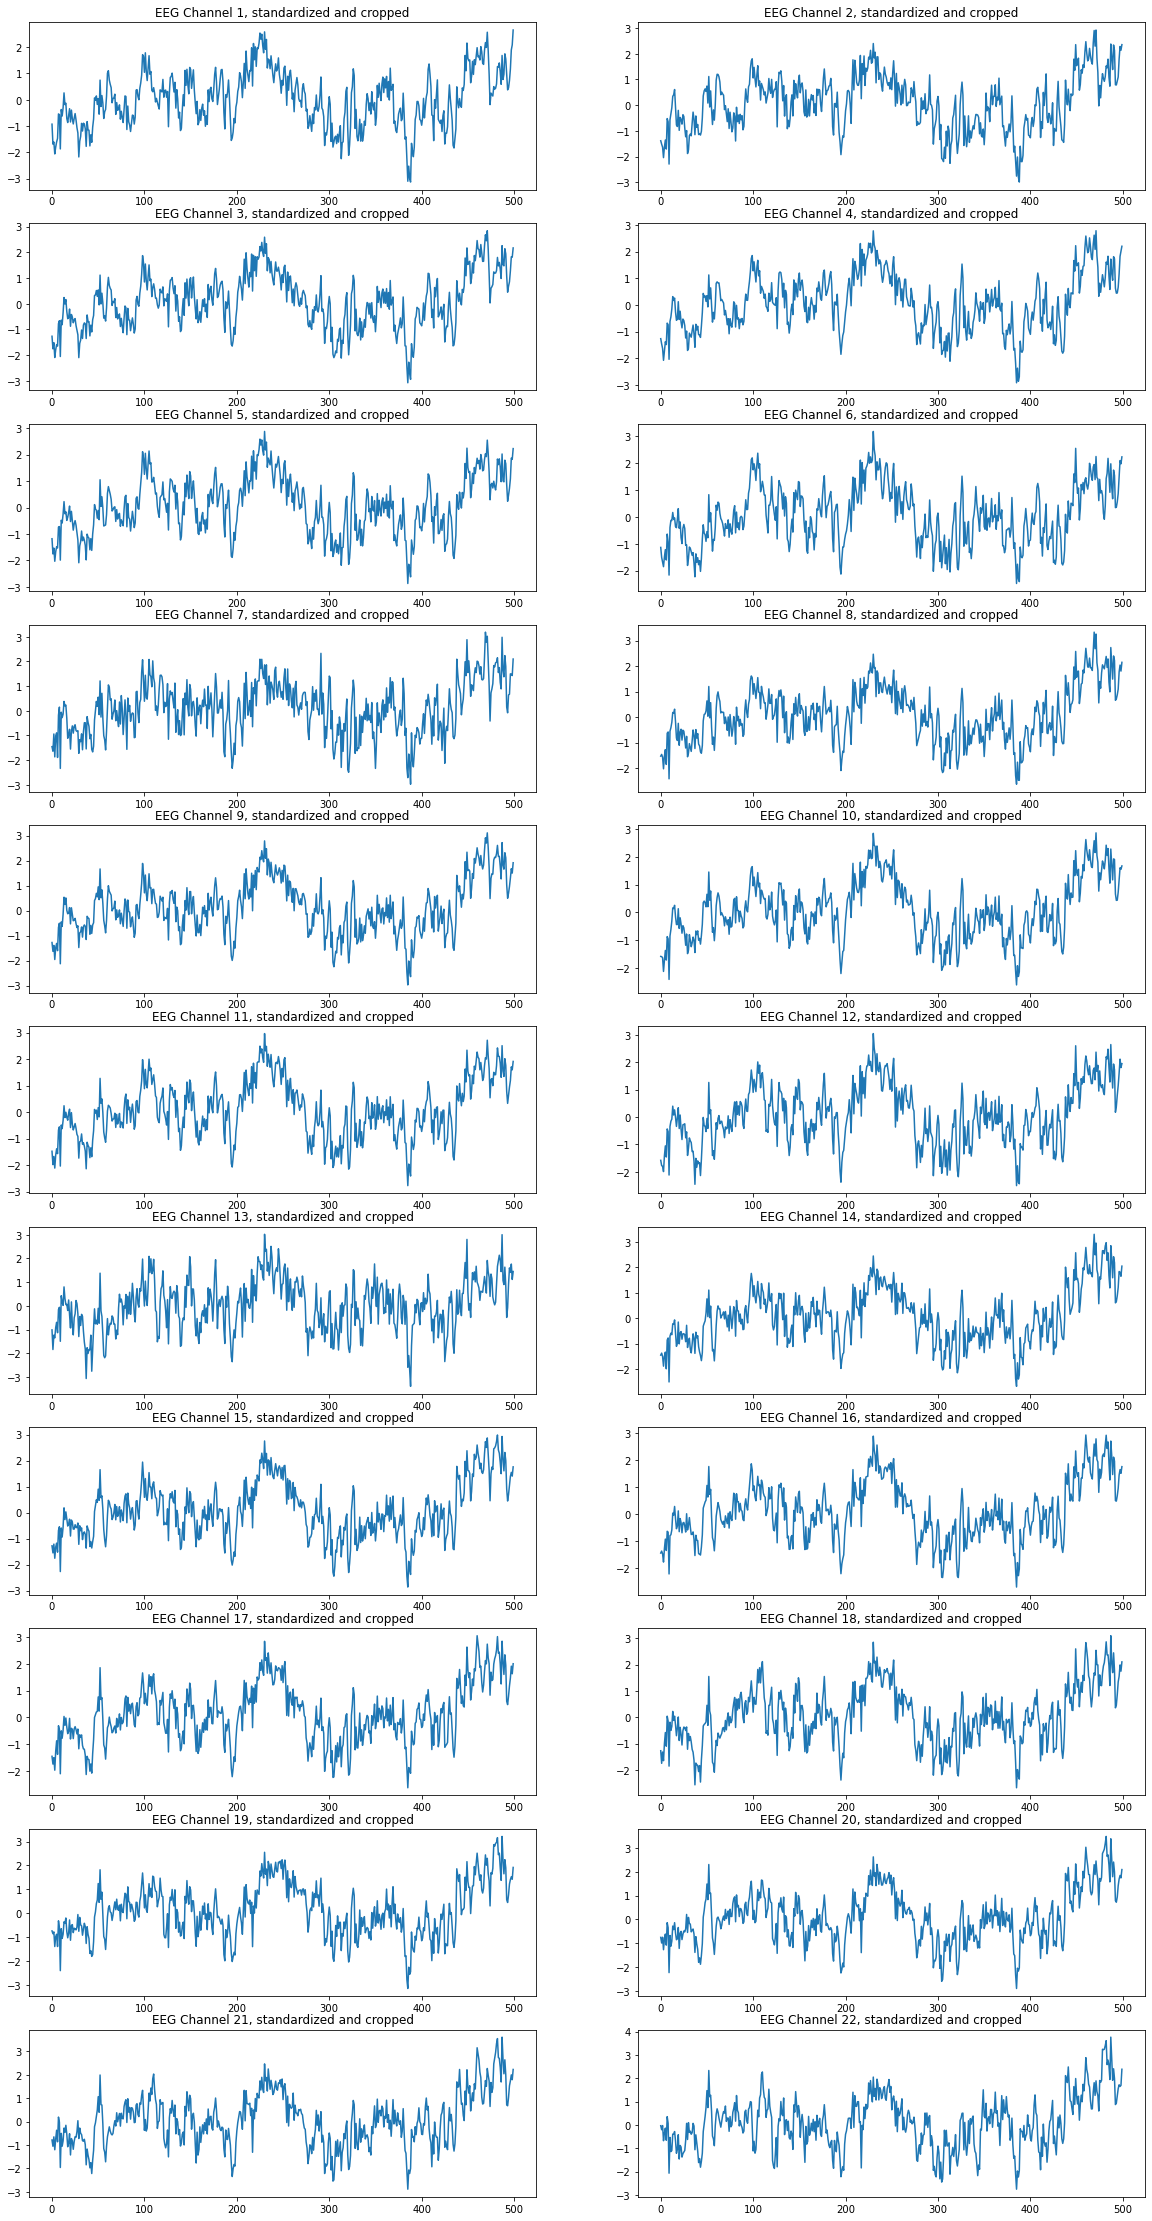

In [11]:
#Take a look at some random capture

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    y = X_train_valid_norm_cropped[eeg_ix,i,:]
    
    axs[int(i/2),count].plot(y)
    axs[int(i/2),count].set_title('EEG Channel {}, standardized and cropped'.format(i+1))
    
    count += 1
    if (count>1):
        count=0

In [12]:
#need to flip the tensor so that it's (examples, timesteps, channels)
X_train_valid_flipped = np.transpose(X_train_valid_norm_cropped, (0,2,1))
print(X_train_valid_flipped.shape)

(2115, 500, 22)


In [21]:
n_comp=16   #This is the number of channels we want to reduce to


X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
print(X_train_valid_reshaped.shape)
X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


#try a PCA on the data
#reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
for i in range(len(X_train_valid_flipped)):
    #print(X_train_valid_flipped[i].shape)
    X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

        
print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

#n_comp=4                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_test_reshaped)                               #fit it to your transformed data
X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
#print(X_test_transformed.shape)
for i in range(len(X_test_flipped)):
    #print(X_test_flipped[i].shape)
    X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_test_transformed = np.transpose(X_test_transformed, (0,2,1))

(1057500, 22)
(2115, 500, 16)
(443, 500, 16)


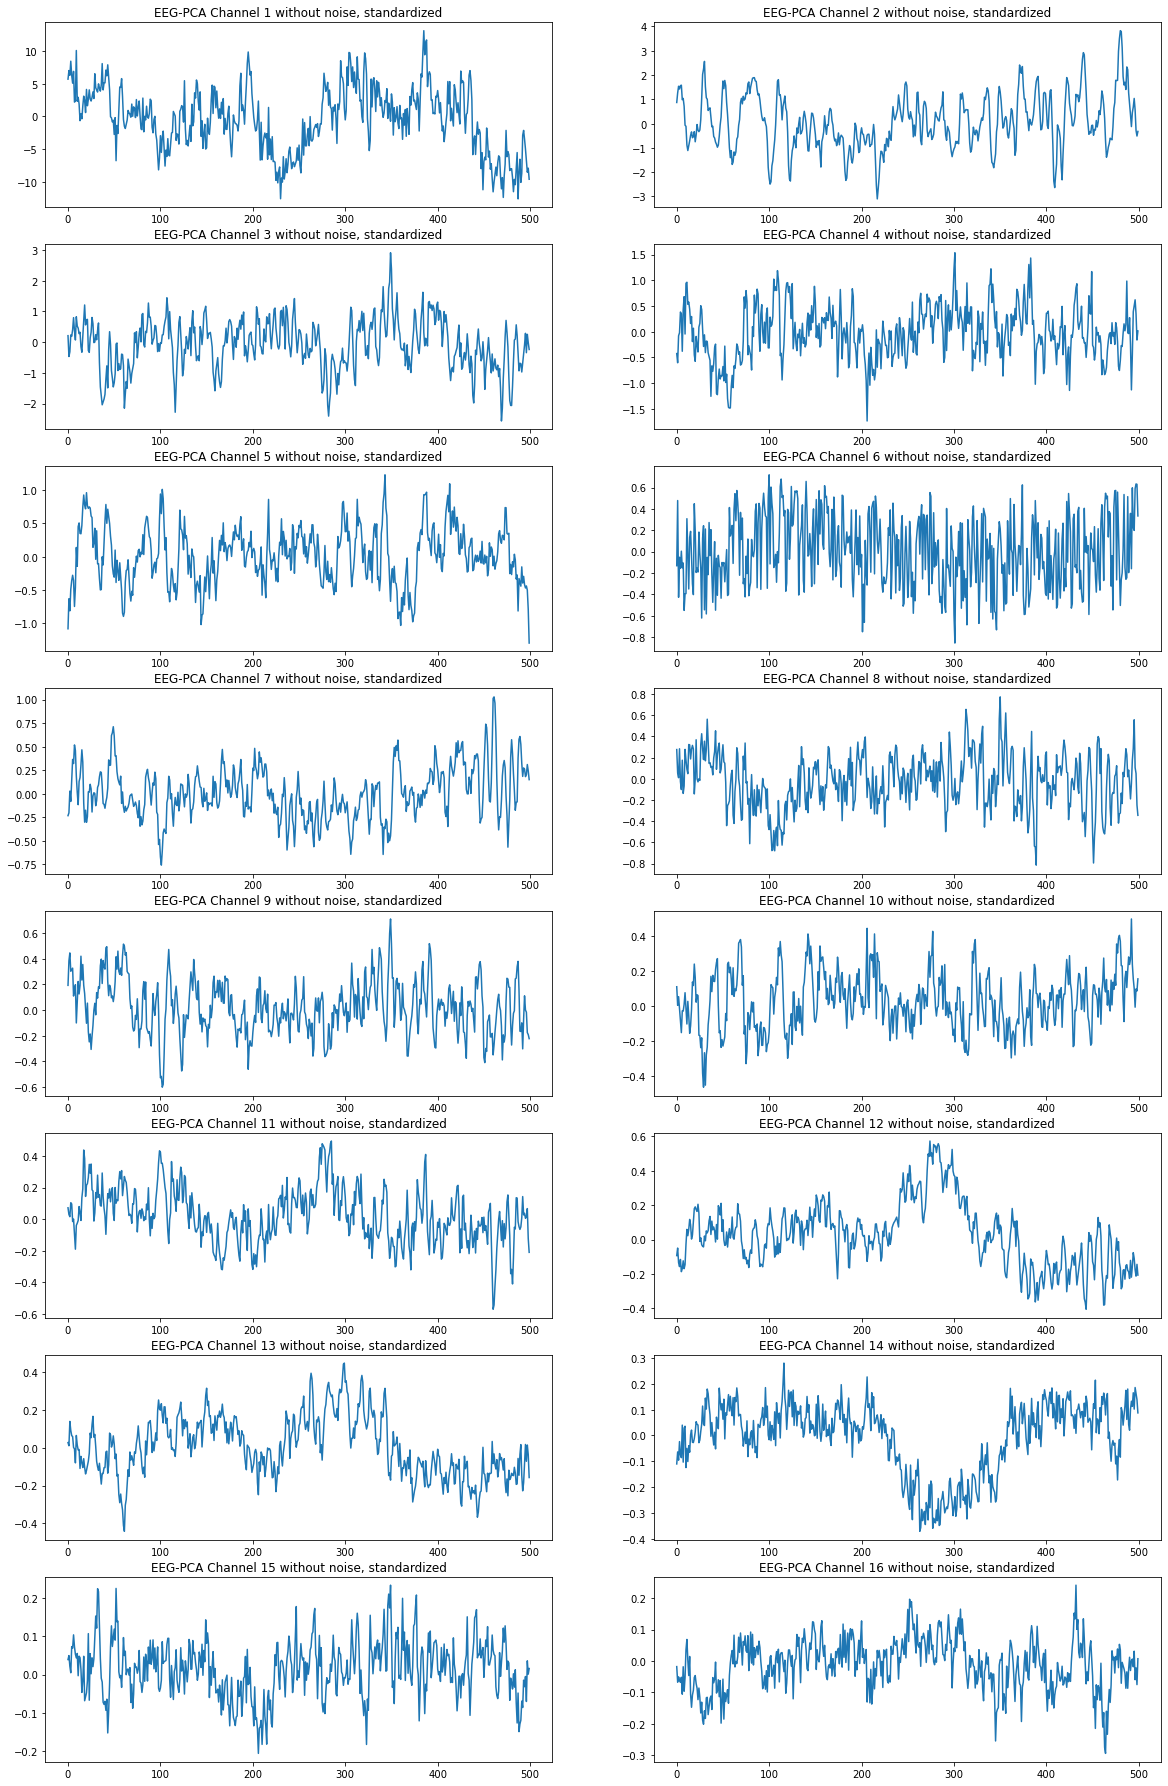

In [24]:
#This is to plot the new channels after PCA

fig, axs = plt.subplots(int(n_comp/2),2,figsize=(20,n_comp*2))

count = 0

eeg_ix = 10

for i in range(n_comp):
    y = X_train_valid_transformed[eeg_ix,i,:]
    
    axs[int(i/2),count].plot(y)
    axs[int(i/2),count].set_title('EEG-PCA Channel {} without noise, standardized'.format(i+1))
    
    count += 1
    if (count>1):
        count=0

In [25]:
## Network for 2s crops

# Input layer is used to instantiate a tensor
# Dimensions are (E,T) -> (22, 1000)
input_ = layers.Input(shape=(n_comp, 500))

# Reshape layer reshapes input into given shape
# output shape is (batch_size,) + target_shape
r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)

# Temporal convolution layer
# kernel_size is (H,W)
# for channels_last input is a 4D-tensor with dims batch_size + (rows, cols, )
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
# c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
#                    activation='elu')(r1)


# Permute layer
p1 = layers.Permute(dims=(2,1,3))(c1)

# Reshape layer
r2 = layers.Reshape((476, n_comp*40))(p1)

# FC layer
d1 = layers.Dense(40, activation='elu')(r2)

# Activation layer using ksquare
sq1 = layers.Activation(ksquare)(d1)

# Mean pooling layer
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)

# Log activation layer
log1 = layers.Activation(klog)(ap1)

# Flatten layer
f1 = layers.Flatten()(log1)

#set dropout to 0.8 for previous best (70.69%)
d2 = layers.Dropout(0.80)(f1)

# Output layer
#output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(f1)
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
# output_ = layers.Dense(4, activation='softmax')(f1)

In [26]:
model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
#opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 500)]         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 500, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 476, 40)       1040      
_________________________________________________________________
permute_1 (Permute)          (None, 476, 16, 40)       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 476, 640)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 476, 40)           25640     
_________________________________________________________________
activation_2 (Activation)    (None, 476, 40

Epoch 1/75
53/53 [==============================] - 5s 86ms/step - loss: 1.8369 - acc: 0.2801 - val_loss: 1.3619 - val_acc: 0.3853
Epoch 2/75
53/53 [==============================] - 4s 82ms/step - loss: 1.4106 - acc: 0.3493 - val_loss: 1.3095 - val_acc: 0.4279
Epoch 3/75
53/53 [==============================] - 4s 82ms/step - loss: 1.3040 - acc: 0.4125 - val_loss: 1.2292 - val_acc: 0.4752
Epoch 4/75
53/53 [==============================] - 5s 90ms/step - loss: 1.2330 - acc: 0.4557 - val_loss: 1.1723 - val_acc: 0.5106
Epoch 5/75
53/53 [==============================] - 6s 108ms/step - loss: 1.1341 - acc: 0.5372 - val_loss: 1.0984 - val_acc: 0.5603
Epoch 6/75
53/53 [==============================] - 6s 107ms/step - loss: 1.0733 - acc: 0.5715 - val_loss: 1.0684 - val_acc: 0.5839
Epoch 7/75
53/53 [==============================] - 6s 104ms/step - loss: 1.0495 - acc: 0.5887 - val_loss: 1.0360 - val_acc: 0.5792
Epoch 8/75
53/53 [==============================] - 6s 106ms/step - loss: 0.9843

Epoch 63/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5721 - acc: 0.8073 - val_loss: 0.8170 - val_acc: 0.7376
Epoch 64/75
53/53 [==============================] - 6s 106ms/step - loss: 0.5410 - acc: 0.8115 - val_loss: 0.8394 - val_acc: 0.7210
Epoch 65/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5395 - acc: 0.8251 - val_loss: 0.8077 - val_acc: 0.7258
Epoch 66/75
53/53 [==============================] - 5s 104ms/step - loss: 0.5148 - acc: 0.8339 - val_loss: 0.8279 - val_acc: 0.7163
Epoch 67/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5442 - acc: 0.8197 - val_loss: 0.8432 - val_acc: 0.7258
Epoch 68/75
53/53 [==============================] - 6s 110ms/step - loss: 0.5233 - acc: 0.8387 - val_loss: 0.8498 - val_acc: 0.7187
Epoch 69/75
53/53 [==============================] - 7s 126ms/step - loss: 0.5318 - acc: 0.8233 - val_loss: 0.8262 - val_acc: 0.7045
Epoch 70/75
53/53 [==============================] - 6s 118ms/step - 

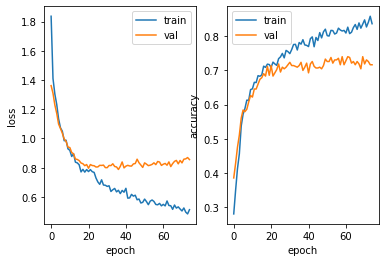

In [27]:
## Training 12

## Wow, best performance now 71.16%


loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])